Pearson correlation between BEV sales and fast-chargers: 0.274 (p=0.656)


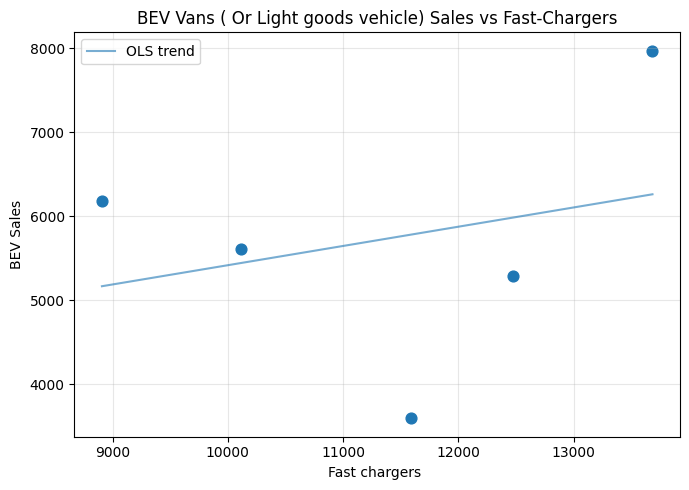

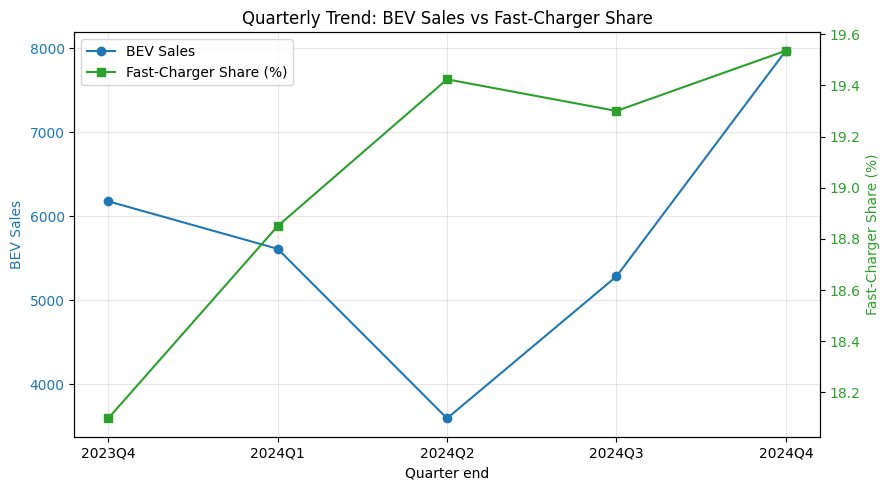

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

df = pd.read_csv('Fast_charger_statistics_dataset.csv')

def to_numeric_clean(s):
    """Remove commas/([x]) and coerce to numeric"""
    return pd.to_numeric(
        pd.Series(s)
          .astype(str)
          .str.replace(',', '', regex=False)
          .str.replace('[x]', '', regex=True)
          .str.strip(),
        errors='coerce'
    )

df['Total Chargers'] = to_numeric_clean(df['Total Chargers'])
df['Fast Chargers']  = to_numeric_clean(df['Fast Chargers'])
df['BEV_Sales']      = to_numeric_clean(df['BEV_Sales'])

q = pd.PeriodIndex(df['Quarter'].astype(str), freq='Q')
df['Date'] = q.to_timestamp(how='end')  

# share of fast chargers (as %)
df['Fast_Share_pct'] = (df['Fast Chargers'] / df['Total Chargers']) * 100

df = df.dropna(subset=['Date', 'BEV_Sales', 'Fast Chargers', 'Total Chargers', 'Fast_Share_pct'])
df = df.sort_values('Date').reset_index(drop=True)

x = df['Fast Chargers'].to_numpy(dtype=float)
y = df['BEV_Sales'].to_numpy(dtype=float)

def safe_pearson(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x2, y2 = x[mask], y[mask]
    if (len(x2) >= 3) and (np.std(x2) > 0) and (np.std(y2) > 0):
        r, p = pearsonr(x2, y2)
        return r, p
    else:
        return np.nan, np.nan

r, p = safe_pearson(x, y)
print(f"Pearson correlation between BEV sales and fast-chargers: {r:.3f} (p={p:.3f})")

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(df['Fast Chargers'], df['BEV_Sales'], s=60, color='tab:blue')
if np.isfinite(r):
    m, b = np.polyfit(df['Fast Chargers'], df['BEV_Sales'], 1)
    xs = np.linspace(df['Fast Chargers'].min(), df['Fast Chargers'].max(), 100)
    ax.plot(xs, m*xs + b, color='tab:blue', alpha=0.6, label='OLS trend')
title_suffix = "" if np.isfinite(r) else " (insufficient points for reliable r)"
ax.set_title("BEV Vans ( Or Light goods vehicle) Sales vs Fast-Chargers"+title_suffix)
ax.set_xlabel("Fast chargers ")
ax.set_ylabel("BEV Sales")
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(df['Quarter'], df['BEV_Sales'], marker='o', color='tab:blue', label='BEV Sales')
ax1.set_ylabel('BEV Sales', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df['Quarter'], df['Fast_Share_pct'], marker='s', color='tab:green',
         label='Fast-Charger Share (%)')
ax2.set_ylabel('Fast-Charger Share (%)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax1.set_title("Quarterly Trend: BEV Sales vs Fast-Charger Share")
ax1.set_xlabel("Quarter end")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='upper left')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()